In [3]:
import numpy as np
import pandas as pd

import warnings; 
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns 
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

# Text processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# algorithm
#from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

<h3>Load data</h3> 

In [4]:
path_data = '../../../yelp_academic_dataset_review.pickle'
data = pd.read_pickle(path_data)

In [5]:
# Removing all ('\n') characters using list comprehensions
data['text'] = [txt.replace('\n', '') for txt in data['text']]

# Taking only text and stars columns
data = data.loc[:, ['text', 'stars']]

<h3>Tokenizer</h3>

In [6]:
#data["tokens"] = data.apply(lambda row: word_tokenize(row["text"]), axis=1)

#data.head()

<h3>Text representation</h3>

The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Therefore, during the preprocessing step, the texts are converted to a more manageable representation.

In [7]:
X = data["text"].tolist()
y = data["stars"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def count_vectorize(data):
    count_vectorizer = CountVectorizer()
    
    embedding = count_vectorizer.fit_transform(data)
    
    return embedding, count_vectorizer

def tfidf_transform(data):
    tfidf_transformer = TfidfTransformer()
    
    text_freq = tfidf_transformer.fit_transform(data)
    
    return text_freq, tfidf_transformer

X_train_counts, count_vectorizer = count_vectorize(X_train)
X_test_counts = count_vectorizer.transform(X_test)

X_train_tfidf, tfidf_transformer = tfidf_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

<h3>Tuning parameters</h3>

In [10]:
#C_values=[1e-4,(1/3)*1e-3,(2/3)*1e-3,1e-3,(1/3)*1e-2,(2/3)*1e-2,1e-2,(1/3)*1e-1,(2/3)*1e-1,1e-1,(1/3),(2/3),1,(1/3)*1e+1,(2/3)*1e+1,1e+1,(1/3)*1e+2,(2/3)*1e+2,1e+2,(1/3)*1e+3,(2/3)*1e+3,1e+3]
#C_values=np.logspace(-4, 3, num=14, endpoint=True, base=10.0, dtype=None)
#C_values for global graph
C_values=[1e-5,1e-4,1e-3,1e-2,1e-1,1,1e+1,1e+2,1e+3,1e+4]
#C_values for zoomed graph
C_values=np.logspace(-2,1,num=10, endpoint=True, base=10.0, dtype=None)

accuracy_means = []
accuracy_stdevs=[]
num_folds=5
seed=42

#temporary only a part of the data
X_train_tfidf_t=X_train_tfidf[:10000]
y_train_t=y_train[:10000]

for C_value in C_values:
    model = LinearSVC(C=C_value)
    
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train_tfidf_t, y_train_t, scoring='accuracy', cv=kfold)
    accuracy_means.append(cv_results.mean())
    accuracy_stdevs.append(cv_results.std())
    
for accuracy_mean, accuracy_stdev, C_value in zip(accuracy_means, accuracy_stdevs, C_values):
    print("%f (%f) with C_value : %r" % (accuracy_mean, accuracy_stdev, C_value))

0.436900 (0.003089) with C_value : 0.01
0.484800 (0.007782) with C_value : 0.021544346900318832
0.524000 (0.003578) with C_value : 0.046415888336127774
0.548800 (0.005887) with C_value : 0.10000000000000001
0.552700 (0.007878) with C_value : 0.21544346900318834
0.547200 (0.009760) with C_value : 0.46415888336127775
0.535500 (0.007550) with C_value : 1.0
0.520700 (0.006038) with C_value : 2.154434690031882
0.508400 (0.005616) with C_value : 4.6415888336127775
0.497200 (0.004179) with C_value : 10.0


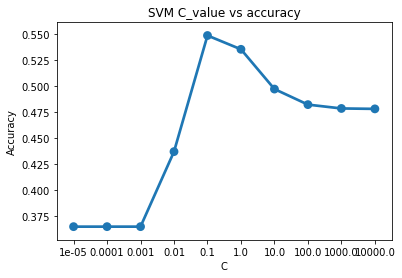

In [9]:
#import decimal
#plt.figure(figsize=(15,15))
#C=[]
#for C_value in C_values:
#    C.append(round(C_value,4))
sns.pointplot(x=C_values, y=accuracy_means)
#plt.semilogx(basex=3)
plt.title("SVM C_value vs accuracy")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.savefig("linearSVM_big.png")

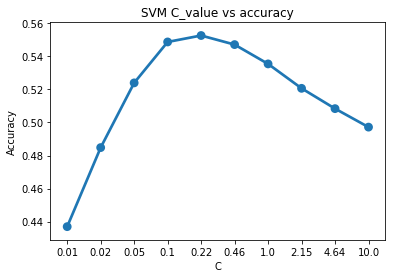

In [13]:
import decimal
#plt.figure(figsize=(15,15))
C=[]
for C_value in C_values:
    C.append(round(C_value,2))
sns.pointplot(x=C, y=accuracy_means)
#plt.semilogx(basex=3)
plt.title("SVM C_value vs accuracy")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.savefig("linearSVM_zoom.png")

<h3>Testing Data<h3>

In [15]:
best_C=C_values[0]
best_accuracy=accuracy_means[0]

X_test_tfidf_t=X_test_tfidf[:2500]
y_test_t=y_test[:2500]
for i in range(len(C_values)):
    if accuracy_means[i]>best_accuracy:
        best_accuracy=accuracy_means[i]
        best_C=C_values[i]

svm_clf = LinearSVC(C=best_C).fit(X_train_tfidf_t,y_train_t)
svm_clf.score(X_test_tfidf_t,y_test_t)

0.57320000000000004